# Preliminaries

Please run all cells in this part to install all packages and download all data

In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install ogb
!pip install transformers
!pip install sentence_transformers

2.2.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 80.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 38.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none

In [2]:
import torch
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch_geometric.data import DataLoader
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util
from torch_geometric.nn import GATConv
from itertools import chain
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
!gdown 1qoCKJyFgMxO8h9SgQoeIkYAPnV5sJfHW
!gdown 1Y6hEqmjr3fXQuW1AvQ_l3ps5Rl2vnZHB
!gdown 1E0G_0_SgjZLb7ikRLtaQKTYC4mx8sBV1
!gdown 1Rm-tajqdiNsfta-yErgMGH3xIKvrBFv4
!gdown 1KDaf1DX3AwwYOuBWhjx6llOBergtwIv4

Downloading...
From (original): https://drive.google.com/uc?id=1qoCKJyFgMxO8h9SgQoeIkYAPnV5sJfHW
From (redirected): https://drive.google.com/uc?id=1qoCKJyFgMxO8h9SgQoeIkYAPnV5sJfHW&confirm=t&uuid=b988d53a-035f-4cb6-b864-d103d0779bba
To: /content/all.pt
100% 825M/825M [00:11<00:00, 73.3MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1Y6hEqmjr3fXQuW1AvQ_l3ps5Rl2vnZHB
From (redirected): https://drive.google.com/uc?id=1Y6hEqmjr3fXQuW1AvQ_l3ps5Rl2vnZHB&confirm=t&uuid=ced86766-f9e9-47df-99ce-9b0674320bf2
To: /content/abstract.pt
100% 825M/825M [00:10<00:00, 79.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1E0G_0_SgjZLb7ikRLtaQKTYC4mx8sBV1
To: /content/nodeidx2paperid.csv
100% 2.94M/2.94M [00:00<00:00, 244MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1Rm-tajqdiNsfta-yErgMGH3xIKvrBFv4
From (redirected): https://drive.google.com/uc?id=1Rm-tajqdiNsfta-yErgMGH3xIKvrBFv4&confirm=t&uuid=0d1ca1d7-ca4e-4b59-a800-ae546cffea9d
To: /content/titlea

In [5]:
dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='dataset/')
data = dataset[0]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

# Baseline Model

In [6]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, num_additional_layers = 0):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.convs = torch.nn.ModuleList()
        for i in range(num_additional_layers):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.1, training=self.training)
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=0.1, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


class GAT(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, num_additional_layers):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_features, hidden_channels, heads=8)
        self.convs = torch.nn.ModuleList()
        for i in range(num_additional_layers):
            self.convs.append(GATConv(hidden_channels * 8, hidden_channels * 8, heads=8))
        self.conv2 = GATConv(hidden_channels * 8, num_classes, heads=1, concat=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.05, training=self.training)
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=0.05, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


In [7]:
split_idx = dataset.get_idx_split()
train_idx, valid_idx, test_idx = split_idx["train"], split_idx["valid"], split_idx["test"]

Please adjust here to choose which baseline model you want to run.

In [8]:
# model = GAT(num_features=data.num_features,
#             hidden_channels=32,
#             num_classes=dataset.num_classes,
#             num_additional_layers = 0).to(device)
model = GCN(num_features=data.num_features,
            hidden_channels=64,
            num_classes=dataset.num_classes,
            num_additional_layers = 0).to(device)

In [9]:
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[train_idx], data.y.squeeze(1)[train_idx])
    loss.backward()
    optimizer.step()
    return loss

for epoch in range(5000):
    loss = train()
    if epoch % 200 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')


Epoch: 0, Loss: 3.6995298862457275
Epoch: 200, Loss: 1.86920964717865
Epoch: 400, Loss: 1.570776104927063
Epoch: 600, Loss: 1.4867894649505615
Epoch: 800, Loss: 1.4529249668121338
Epoch: 1000, Loss: 1.4275974035263062
Epoch: 1200, Loss: 1.4151098728179932
Epoch: 1400, Loss: 1.4044201374053955
Epoch: 1600, Loss: 1.394255518913269
Epoch: 1800, Loss: 1.3854221105575562
Epoch: 2000, Loss: 1.3803577423095703
Epoch: 2200, Loss: 1.376020908355713
Epoch: 2400, Loss: 1.3719271421432495
Epoch: 2600, Loss: 1.3674284219741821
Epoch: 2800, Loss: 1.3633217811584473
Epoch: 3000, Loss: 1.3619248867034912
Epoch: 3200, Loss: 1.3591666221618652
Epoch: 3400, Loss: 1.3550549745559692
Epoch: 3600, Loss: 1.3542957305908203
Epoch: 3800, Loss: 1.3518812656402588
Epoch: 4000, Loss: 1.3516632318496704
Epoch: 4200, Loss: 1.3473693132400513
Epoch: 4400, Loss: 1.3450846672058105
Epoch: 4600, Loss: 1.3443336486816406
Epoch: 4800, Loss: 1.344861626625061


In [10]:
def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Get the index of the max log-probability
    correct = pred[test_idx] == data.y.squeeze(1)[test_idx]  # Compare against ground-truth labels
    acc = int(correct.sum()) / len(test_idx)  # Compute accuracy
    return acc

accuracy = test()
print(f'Validation Accuracy: {accuracy}')


Validation Accuracy: 0.5363866427998272


# Getting LM embedding

In [11]:
## reads raw texts for each node
df = pd.read_csv('/content/titleabs.tsv', header = None, sep = '\t',
                 names = ["id", "title", "abstract"])
df.head()

,id,title,abstract
0,200971,ontology as a source for rule generation,This paper discloses the potential of OWL (Web...
1,549074,a novel methodology for thermal analysis a 3 d...,The semiconductor industry is reaching a fasci...
2,630234,spreadsheets on the move an evaluation of mobi...,The power of mobile devices has increased dram...
3,803423,multi view metric learning for multi view vide...,Traditional methods on video summarization are...
4,1102481,big data analytics in future internet of things,Current research on Internet of Things (IoT) m...


## Sentence transformer (DO NOT RUN)

Getting the sentence transformer embedding. We have already computed these and stored them in drive. Please do not run it again (if you are starting fresh, only run this once).

In [9]:
df['combined'] = df['title'] + '\n' + df['abstract']
model = SentenceTransformer('all-mpnet-base-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
abstract_embedding = model.encode(df["abstract"].tolist(), show_progress_bar = True)

Batches:   0%|          | 0/5617 [00:00<?, ?it/s]

In [ ]:
torch.save(abstract_embedding, "abstract.pt")

array([[ 0.06709803, -0.00260303, -0.03525066, ...,  0.01122417,
         0.00227784, -0.0024321 ],
       [ 0.05002695, -0.06211789, -0.00733226, ..., -0.04582901,
        -0.05350998, -0.00621984],
       [-0.01707286, -0.01199244, -0.01796226, ...,  0.05112026,
         0.00148729, -0.00747634],
       ...,
       [-0.01329558,  0.11748262, -0.03455109, ...,  0.00232268,
        -0.03262008, -0.04931226],
       [ 0.02520715,  0.0554713 , -0.00194554, ...,  0.02012073,
        -0.00034638, -0.03606958],
       [ 0.00272224,  0.01826248, -0.0160021 , ...,  0.03682491,
        -0.02521036, -0.06207232]], dtype=float32)

In [ ]:
all_embedding = model.encode(df["combined"].tolist(), show_progress_bar = True)

Batches:   0%|          | 0/5617 [00:00<?, ?it/s]

In [ ]:
torch.save(all_embedding, "all.pt")

In [ ]:
title_embedding = model.encode(df["title"].tolist(), show_progress_bar = True)

Batches:   0%|          | 0/5617 [00:00<?, ?it/s]

In [ ]:
torch.save(title_embedding, "title.pt")

In [ ]:
log_abstract = {
    "title": title_embedding,
    "abstract": abstract_embedding,
    "all": all_embedding,
}
torch.save(log_abstract, "log_abstract.pt")


In [ ]:
from google.colab import files
files.download("/content/log_abstract.pt")

# Approach 1: Using LM feature for GNN

In [12]:
nodeid2paperid = pd.read_csv('/content/nodeidx2paperid.csv')
nodeid2paperid.head()

,node idx,paper id
0,0,9657784
1,1,39886162
2,2,116214155
3,3,121432379
4,4,231147053


In [13]:
abstract_embedding = torch.load('abstract.pt')
all_embedding = torch.load('/content/all.pt')

NOTE: `lm_emb = all_embedding` use the combined embedding for title + abstract. change it to `lm_emb = abstract_embedding` to use embedding for abstract only, etc.

In [14]:
paperids = nodeid2paperid['paper id'].tolist()
paperids_df = df.id.tolist()
paperid2dfid = {paperid: i for i, paperid in enumerate(paperids_df)}
dfids = [paperid2dfid[i] for i in paperids]
lm_emb = all_embedding ## TODO: could change this
x_lm = torch.tensor(lm_emb[torch.tensor(dfids)]).to(device)
data.x_lm = x_lm.to(device)
data.num_lm_features = 768

## could add
data.num_lm_features = 768 + 128
data.x_lm = torch.cat((data.x, data.x_lm), dim=1)

In [15]:
# model = GAT(num_features=data.num_lm_features,
#             hidden_channels=32,
#             num_classes=dataset.num_classes,
#             num_additional_layers = 0).to(device)
model = GCN(num_features=data.num_lm_features,
            hidden_channels=64,
            num_classes=dataset.num_classes,
            num_additional_layers = 0).to(device)

In [16]:
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-5)
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x_lm, data.edge_index)
    loss = F.nll_loss(out[train_idx], data.y.squeeze(1)[train_idx])
    with torch.no_grad():
      val_loss = F.nll_loss(out[valid_idx], data.y.squeeze(1)[valid_idx])
    loss.backward()
    optimizer.step()
    return loss, val_loss

for epoch in range(2000):  ## change this to 5000, here is 2000 for saving time, we ran it for 5000 epochs for all experiments.
    loss, val_loss = train()
    if epoch % 200 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}, valid loss: {val_loss.item()}')

Epoch: 0, Loss: 3.777076005935669, valid loss: 3.754049301147461
Epoch: 200, Loss: 1.1956003904342651, valid loss: 1.173519492149353
Epoch: 400, Loss: 1.0399047136306763, valid loss: 1.0381194353103638
Epoch: 600, Loss: 0.9864274263381958, valid loss: 1.001455545425415
Epoch: 800, Loss: 0.9527455568313599, valid loss: 0.9856254458427429
Epoch: 1000, Loss: 0.9250034093856812, valid loss: 0.9769924879074097
Epoch: 1200, Loss: 0.9044860601425171, valid loss: 0.9672080278396606
Epoch: 1400, Loss: 0.8855103254318237, valid loss: 0.9640610814094543
Epoch: 1600, Loss: 0.8698300719261169, valid loss: 0.9623537659645081
Epoch: 1800, Loss: 0.8521376252174377, valid loss: 0.9573588371276855


In [17]:
def test():
    model.eval()
    out = model(data.x_lm, data.edge_index)
    pred = out.argmax(dim=1)  # Get the index of the max log-probability
    correct = pred[test_idx] == data.y.squeeze(1)[test_idx]  # Compare against ground-truth labels
    acc = int(correct.sum()) / len(test_idx)  # Compute accuracy
    return acc

accuracy = test()
print(f'Validation Accuracy: {accuracy}')

Validation Accuracy: 0.6941135320864967


# Directly optimizing an LM for classification

Here, we directly use an LM to predict the paper class from abstract + title.

In [13]:
from copy import deepcopy
train_df = df.iloc[
    [paperid2dfid[i] for i in nodeid2paperid.iloc[train_idx.tolist(), :]["paper id"].tolist()],
    :
]
train_df.loc[:, "label"] = deepcopy(data.y.squeeze(1)[train_idx].cpu().numpy())
dev_df = df.iloc[
    [paperid2dfid[i] for i in nodeid2paperid.iloc[valid_idx.tolist(), :]["paper id"].tolist()],
    :
]
dev_df.loc[:, "label"] = deepcopy(data.y.squeeze(1)[valid_idx].cpu().numpy())
test_df = df.iloc[
    [paperid2dfid[i] for i in nodeid2paperid.iloc[test_idx.tolist(), :]["paper id"].tolist()],
    :
]
test_df.loc[:, "label"] = deepcopy(data.y.squeeze(1)[test_idx].cpu().numpy())

<ipython-input-13-7af28983a24b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, "label"] = deepcopy(data.y.squeeze(1)[train_idx].cpu().numpy())
<ipython-input-13-7af28983a24b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_df.loc[:, "label"] = deepcopy(data.y.squeeze(1)[valid_idx].cpu().numpy())
<ipython-input-13-7af28983a24b>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

In [14]:
class simple_dataset(Dataset):
  def __init__(self, df, tokenizer):
    df = df.reset_index(drop=True)
    self.df = df
    self.paperid2nodeid = {nodeid2paperid["paper id"][i]: nodeid2paperid["node idx"][i] for i in range(len(nodeid2paperid))}

    self.tokenizer = tokenizer
  def __len__(self):
    return  len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    title = row['title']
    abstract = row['abstract']
    text = title + "\n" + abstract
    output = self.tokenizer(text, return_tensors="pt", padding="max_length",
                            truncation=True,
                            max_length = 256)
    for k in output: output[k] = torch.squeeze(output[k])
    output["label"] = torch.tensor(row['label'])
    output["nodeid"] = torch.tensor(self.paperid2nodeid[row['id']])
    return output

class classification_lm(torch.nn.Module):
  def __init__(self, base, num_classes):
    super(classification_lm, self).__init__()
    self.base = base
    self.head = torch.nn.Linear(768, num_classes)

  def forward(self, input_ids, attention_mask):
    outputs = self.base(input_ids, attention_mask=attention_mask)
    # return self.head(outputs.pooler_output)
    return self.head(outputs.last_hidden_state[:, 0])

model_name = "distilbert/distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
df_data_train = simple_dataset(train_df, tokenizer)
df_data_dev = simple_dataset(dev_df, tokenizer)
df_data_test = simple_dataset(test_df, tokenizer)
train_loader = DataLoader(df_data_train, batch_size=8, shuffle = True)
dev_loader = DataLoader(df_data_dev, batch_size=8, shuffle = True)
test_loader = DataLoader(df_data_test, batch_size=8, shuffle = True)

lm_base = AutoModel.from_pretrained(model_name)
lm = classification_lm(lm_base, 40)
lm.to(device)

def train_lm(train_loader, dev_loader, test_loader):
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(lm.parameters(), lr=2e-5)
  for epoch in range(3):
    lm.train()
    tbar_train = tqdm(train_loader, position=0, leave=True)
    for batch in tbar_train:
      optimizer.zero_grad()
      input_ids = batch.input_ids.to(device)
      attention_mask = batch.attention_mask.to(device)
      logits = lm(input_ids, attention_mask=attention_mask)
      loss = criterion(logits, batch.label.to(device))
      loss.backward()
      optimizer.step()
    dev_acc = eval(lm, dev_loader)
    test_acc = eval(lm, test_loader)
    print(f"\n Epoch {epoch}, dev acc {dev_acc}, test acc {test_acc} \n")

def eval(lm, loader):
  with torch.no_grad():
    lm.eval()
    preds = []
    labels = []
    tbar = tqdm(loader, position=0, leave=True)
    for batch in tbar:
      input_ids = batch.input_ids.to(device)
      attention_mask = batch.attention_mask.to(device)
      outputs = lm(input_ids, attention_mask=attention_mask)
      pred = outputs.argmax(dim=1).detach().cpu()
      preds.append(pred)
      labels.append(batch.label)
    acc = (torch.cat(preds) == torch.cat(labels)).sum().item() / len(torch.cat(preds))
    return acc

# train_lm(train_loader, dev_loader, test_loader)




tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
torch.save(
    {
    'model_state_dict': lm.state_dict(),
    },
    '/content/model_checkpoint.pth')

In [ ]:
from google.colab import files
files.download('/content/model_checkpoint.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Approach 2: Contrastive Learning

Specify your config below; whether to use approach 1 (`use_lm_feature=True`) for contrastive learning

In [15]:
use_lm_feature = True
if use_lm_feature:
  data.emb = data.x_lm
  data.emb_size = data.num_lm_features
else:
  data.emb = data.x
  data.emb_size = data.num_features

In [16]:
class GCN_con(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, num_additional_layers = 0):
        super(GCN_con, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.convs = torch.nn.ModuleList()
        for i in range(num_additional_layers):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
        self.conv2 = GCNConv(hidden_channels, num_classes)
        self.proj = proj(hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.1, training=self.training)
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=0.1, training=self.training)
        y = self.conv2(x, edge_index)
        return F.log_softmax(y, dim=1), self.proj(x)


class GAT_con(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, num_additional_layers):
        super(GAT_con, self).__init__()
        self.conv1 = GATConv(num_features, hidden_channels, heads=8)
        self.convs = torch.nn.ModuleList()
        for i in range(num_additional_layers):
            self.convs.append(GATConv(hidden_channels * 8, hidden_channels * 8, heads=8))
        self.conv2 = GATConv(hidden_channels * 8, num_classes, heads=1, concat=True)
        self.proj = proj(hidden_channels * 8)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.05, training=self.training)
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=0.05, training=self.training)
        y = self.conv2(x, edge_index)
        return F.log_softmax(y, dim=1), self.proj(x)

class proj(torch.nn.Module):
    def __init__(self, input_dim, proj_dim=128):
        super().__init__()
        self.linear = torch.nn.Linear(input_dim, proj_dim)
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        return self.linear(self.activation(x))

In [18]:
gnn = GCN_con(num_features=data.num_lm_features,
            hidden_channels=64,
            num_classes=dataset.num_classes,
            num_additional_layers = 0).to(device)
# gnn = GAT_con(num_features=data.emb_size,
#             hidden_channels=32,
#             num_classes=dataset.num_classes,
#             num_additional_layers = 0).to(device)

In [19]:
data = data.to(device)
optimizer = torch.optim.Adam(gnn.parameters(), lr=0.001, weight_decay=5e-4)
def train():
    gnn.train()
    optimizer.zero_grad()
    out, _ = gnn(data.emb, data.edge_index)
    loss = F.nll_loss(out[train_idx], data.y.squeeze(1)[train_idx])
    loss.backward()
    optimizer.step()
    return loss

for epoch in range(5000):
    loss = train()
    if epoch % 200 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

Epoch: 0, Loss: 3.7117953300476074
Epoch: 200, Loss: 1.2116265296936035
Epoch: 400, Loss: 1.0787447690963745
Epoch: 600, Loss: 1.0346462726593018
Epoch: 800, Loss: 1.0126497745513916
Epoch: 1000, Loss: 0.9944066405296326
Epoch: 1200, Loss: 0.9831110239028931
Epoch: 1400, Loss: 0.9736768007278442
Epoch: 1600, Loss: 0.9667458534240723
Epoch: 1800, Loss: 0.9636861681938171
Epoch: 2000, Loss: 0.9560675024986267
Epoch: 2200, Loss: 0.9512990117073059
Epoch: 2400, Loss: 0.9489309191703796
Epoch: 2600, Loss: 0.9468228220939636
Epoch: 2800, Loss: 0.9446706771850586
Epoch: 3000, Loss: 0.941193699836731
Epoch: 3200, Loss: 0.9405066967010498
Epoch: 3400, Loss: 0.9387608766555786
Epoch: 3600, Loss: 0.9374501705169678
Epoch: 3800, Loss: 0.9350242614746094
Epoch: 4000, Loss: 0.9354428648948669
Epoch: 4200, Loss: 0.9335297346115112
Epoch: 4400, Loss: 0.9333879351615906
Epoch: 4600, Loss: 0.9317354559898376
Epoch: 4800, Loss: 0.9301475286483765


Note that here, `lm.load_state_dict(torch.load('/content/model_checkpoint.pth')["model_state_dict"])` loads the LM trained on node classification. If you comment it out, we will not be using a fine-tuned LM for contrastive learning.

In [20]:

model_name = "distilbert/distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
df_data_train = simple_dataset(train_df, tokenizer)
df_data_dev = simple_dataset(dev_df, tokenizer)
df_data_test = simple_dataset(test_df, tokenizer)
train_loader = DataLoader(df_data_train, batch_size=8, shuffle = True)
dev_loader = DataLoader(df_data_dev, batch_size=8, shuffle = True)
test_loader = DataLoader(df_data_test, batch_size=8, shuffle = True)

lm_base = AutoModel.from_pretrained(model_name)
lm = classification_lm(lm_base, 40)

## LOAD LM todo
lm.load_state_dict(torch.load('/content/model_checkpoint.pth')["model_state_dict"])
lm.proj = proj(768)

lm.to(device)

classification_lm(
  (base): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linea

In [21]:
def test(gnn):
    gnn.eval()
    out, _ = gnn(data.emb, data.edge_index)
    pred = out.argmax(dim=1)  # Get the index of the max log-probability
    correct = pred[test_idx] == data.y.squeeze(1)[test_idx]  # Compare against ground-truth labels
    acc = int(correct.sum()) / len(test_idx)  # Compute accuracy
    return acc

accuracy = test(gnn)
print(f'Validation Accuracy: {accuracy}')

Validation Accuracy: 0.6988251754006954


In [22]:
def contrastive_loss(lm_emb, gnn_emb, temperature=0.07):
    lm_emb_norm = F.normalize(lm_emb, p=2, dim=1)
    gnn_emb_norm = F.normalize(gnn_emb, p=2, dim=1)
    logits_lm_gnn = torch.matmul(lm_emb_norm, gnn_emb_norm.T) / temperature
    logits_gnn_lm = torch.matmul(gnn_emb_norm, lm_emb_norm.T) / temperature
    labels = torch.arange(len(lm_emb)).to(lm_emb.device)
    loss_lm = F.cross_entropy(logits_lm_gnn, labels)
    loss_gnn = F.cross_entropy(logits_gnn_lm, labels)
    return (loss_lm + loss_gnn) / 2

def train_contrastive(train_loader, dev_loader, test_loader, lm, gnn):
  gnn.train()
  criterion = torch.nn.CrossEntropyLoss()
  # optimizer = torch.optim.Adam(chain(lm.parameters(), gnn.parameters()), lr=2e-5)
  optimizer_gnn = torch.optim.Adam(gnn.parameters(), lr=0.001, weight_decay = 5e-4)
  optimizer_lm = torch.optim.Adam(lm.parameters(), lr=2e-5)
  count = 0
  for epoch in range(2):
    lm.train()
    tbar_train = tqdm(train_loader, position=0, leave=True)
    gnn_acc = 0
    for batch in tbar_train:
      gnn.train()
      lm.train()
      ## get lm embedding
      optimizer.zero_grad()
      input_ids = batch.input_ids.to(device)
      attention_mask = batch.attention_mask.to(device)
      lm_emb = lm.proj(lm.base(input_ids, attention_mask)["last_hidden_state"][:, 0])

      ## get gnn embedding
      logits_gnn_all, gnn_emb_all = gnn(data.emb, data.edge_index)
      gnn_emb = gnn_emb_all[batch.nodeid]
      logits_gnn = logits_gnn_all[batch.nodeid]

      ## contrastive loss
      infonce_loss = contrastive_loss(lm_emb, gnn_emb)

      ## classification loss
      logits_lm = lm(input_ids, attention_mask)
      lm_classification_loss = criterion(logits_lm, batch.label.to(device))
      # gnn_classification_loss = criterion(logits_gnn, batch.label.to(device))
      gnn_classification_loss = F.nll_loss(logits_gnn_all[train_idx], data.y.squeeze(1)[train_idx].to(device))


      ## add loss
      loss = lm_classification_loss + gnn_classification_loss + infonce_loss
      loss.backward()
      # optimizer.step()
      optimizer_lm.step()
      optimizer_gnn.step()

      count += 1
      if count % 1000 == 0:
        gnn_acc = test(gnn)

      tbar_train.set_postfix(loss=loss.item(), gnn_acc = gnn_acc)
    dev_acc_lm = eval(lm, dev_loader)
    test_acc_lm = eval(lm, test_loader)
    gnn_acc = test(gnn)
    print(f"\n LM: Epoch {epoch}, dev acc {dev_acc_lm}, test acc {test_acc_lm} \n")
    print(f"\n GNN: Epoch {epoch}, acc {gnn_acc} \n")
  return lm, gnn
lm, gnn = train_contrastive(train_loader, dev_loader, test_loader, lm, gnn)

100%|██████████| 6076/6076 [02:51<00:00, 35.45it/s]


 LM: Epoch 0, dev acc 0.07627772744051814, test acc 0.05861778079542415 


 GNN: Epoch 0, acc 0.6990720737403041 



# t-sne visualization

In [ ]:
use_lm_feature = True
if use_lm_feature:
  data.emb = data.x_lm
  data.emb_size = data.num_lm_features
else:
  data.emb = data.x
  data.emb_size = data.num_features

In [ ]:
gnn = GCN_con(num_features=data.emb_size,
            hidden_channels=64,
            num_classes=dataset.num_classes,
            num_additional_layers = 0).to(device)

In [ ]:
data = data.to(device)
optimizer = torch.optim.Adam(gnn.parameters(), lr=0.001, weight_decay=5e-4)
def train():
    gnn.train()
    optimizer.zero_grad()
    out, _ = gnn(data.emb, data.edge_index)
    loss = F.nll_loss(out[train_idx], data.y.squeeze(1)[train_idx])
    loss.backward()
    optimizer.step()
    return loss

for epoch in range(5000):
    loss = train()
    if epoch % 200 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

Epoch: 0, Loss: 3.727536201477051
Epoch: 200, Loss: 1.1924127340316772
Epoch: 400, Loss: 1.068192958831787
Epoch: 600, Loss: 1.028207540512085
Epoch: 800, Loss: 1.0056724548339844
Epoch: 1000, Loss: 0.9896546006202698
Epoch: 1200, Loss: 0.977752149105072
Epoch: 1400, Loss: 0.9703963994979858
Epoch: 1600, Loss: 0.9649154543876648
Epoch: 1800, Loss: 0.96042799949646
Epoch: 2000, Loss: 0.9545736312866211
Epoch: 2200, Loss: 0.9524317383766174
Epoch: 2400, Loss: 0.9485260248184204
Epoch: 2600, Loss: 0.9458579421043396
Epoch: 2800, Loss: 0.944022536277771
Epoch: 3000, Loss: 0.9427605271339417
Epoch: 3200, Loss: 0.9391101598739624
Epoch: 3400, Loss: 0.9373682141304016
Epoch: 3600, Loss: 0.9361087083816528
Epoch: 3800, Loss: 0.9351071119308472
Epoch: 4000, Loss: 0.9341258406639099
Epoch: 4200, Loss: 0.9325274229049683
Epoch: 4400, Loss: 0.9323749542236328
Epoch: 4600, Loss: 0.9316297769546509
Epoch: 4800, Loss: 0.9304457902908325


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.002s...
[t-SNE] Computed neighbors for 2000 samples in 0.065s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.482092
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.066559
[t-SNE] KL divergence after 1000 iterations: 1.186665


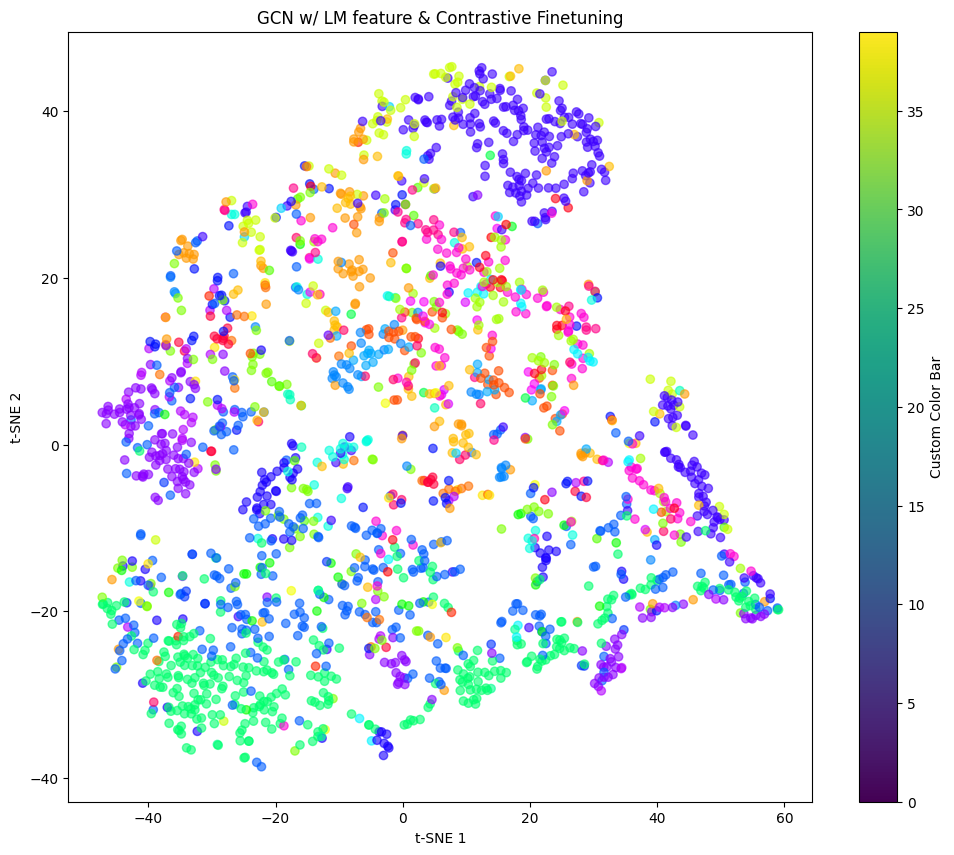

In [36]:
gnn.eval()

_, embeddings = gnn(data.emb, data.edge_index)

embeddings_np = embeddings.detach().cpu().numpy()
labels_np = data.y.squeeze().cpu().numpy()
random_idx = np.random.choice(len(embeddings_np), 2000, replace=False)
embeddings_np = embeddings_np[random_idx]
labels_np = labels_np[random_idx]

tsne = TSNE(n_components=2, random_state=0, verbose = 1)
X_reduced = tsne.fit_transform(embeddings_np)

# Plotting
fig, ax = plt.subplots(figsize=(12, 10))
# plt.figure(figsize=(12, 10))
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels_np, cmap='hsv', alpha=0.6)
plt.colorbar(scatter)

# import matplotlib.colors as mcolors
# # Generate a color bar with a different colormap
# # Here 'hot' is used for demonstration; replace it with any colormap you prefer
# norm = mcolors.Normalize(vmin=0, vmax=39)
# sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
# sm.set_array([])

# # Add the color bar
# cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
# cbar.set_label('Custom Color Bar')

## note: you should manually change the title.
plt.title('GCN w/ LM feature & Contrastive Finetuning')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()